<a href="https://colab.research.google.com/github/ryosato12/co-act/blob/main/coactivation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the enviroment
We first installed all required packages and imported them. Then, we queried how many insertions and sessions there are. The IBL reproducible electrophysiology dataset has EIDS and PIDS, which identifies the specific probe in a session and the entire recording session. We had 83 insertions and 83 sessions. We chose the first insertion, which had data for the visual cortex, CA1 hippocampus, and thalamus—the brain regions we were interested in. We sampled all 83 sessions. We loaded all neural data and obtained the indicies for specific brain regions.

In [ ]:
# @title Installing packages and importing libraries

! pip install ONE-api
! pip install ibllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainbox.io.one import SpikeSortingLoader
from brainbox.plot import peri_event_time_histogram
from brainbox.singlecell import calculate_peths

from ibllib.atlas import AllenAtlas
from one.api import ONE

from brainbox.population import decode
from matplotlib.axis import YAxis
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Lasso
from sklearn.model_selection import KFold

one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international', silent=True)
ba = AllenAtlas()

In [ ]:
ba

In [ ]:
# @title Finding the number of insertions and sessions

insertions = one.alyx.rest('insertions', 'list', django='datasets__tags__name,2022_Q2_IBL_et_al_RepeatedSite')
pids = [i['id'] for i in insertions]
print(f'Found {len(insertions)} insertions')

#sessions = one.alyx.rest('sessions', 'list', tag='2022_Q2_IBL_et_al_RepeatedSite')
#eids = [i['id'] for i in sessions]
#print(f'Found {len(sessions)} sessions')

Found 83 insertions


In [ ]:
# @title Data retrival and loading

# Load in the neural data of the first insertion
sl = SpikeSortingLoader(pid=pids[0],  one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)

# Get the neuron indices
VIS_neurons = [i for i, acronym in enumerate(clusters['acronym']) if 'VIS' in acronym]
CA1_neurons = [i for i, acronym in enumerate(clusters['acronym']) if 'CA1' in acronym]
PO_neurons = [i for i, acronym in enumerate(clusters['acronym']) if 'PO' in acronym]


# Functions
We then developed functions for obtaining the correlation coefficient matrix and predicting the weights of our model. Our null model is the accuracy of the choice, which is represented as feedback type or whether the mice received a reward or not. The IBL website indicates that the feedback type has values +1, 0, -1 or reward, no choice, or no reward, there was no 0 over 83 sessions. Variables we used for the logisic regression were the activity of three brain regions and the feedback type for the mice's choice. The hyperparameters we chose for the cross-validation was K-Fold split of 5. We did not use any regularization because the null model and the accuracy of our model were similar. The time intervals we binned was 20 ms until 400 ms before the stimulus onset to assess the co-activation between the brain regions if they are important for response. We modified our data by making a correlation coefficient matrix, where each diagonal element was the average activity of a brain region across time. The t-test was used to determine the signifance of the weights predicted to the null model.



This function calculates the correlation coefficient matrix of three brain regions. We chose the visual cortex, thalamus, and CA1 hippocampus. The function gets the matrix of size of the length of trials by the correlation between brain regions and itself. The function replaces the diagonal elements of the matrix with the average activity of the brain region to also predict the performance of activity of individual brain regions. In certain cases, there is no activity in a brain region, which we excluded from our data in later function.  

In [ ]:
def get_corr_coef_matrix(brain_region1, brain_region2, brain_region3):
  """
  Obtains the correlation matrix between three brain regions
    Arguments:
      brain_region1: (lst) the indices of specific brain region
      brain_region2: (lst) the indices of specific brain region
      brain_region3: (lst) the indices of specific brain region
    Returns:
      Correlation matrix between three brain regions
  """

  # Create an empty matrix to store the correlation matrix per trial
  corr_coef_matrix_all_trials = np.zeros((len(trials['stimOn_times']), 6))

  # Load data in bins
  ts = trials['stimOn_times'] + np.linspace(-.4,0,20).reshape((-1,1))
  ts = ts.T
  intervals = np.vstack((np.ndarray.flatten(ts[:,0:-1]), np.ndarray.flatten(ts[:,1:]))).T

  matrix, cluster_ids_out = decode.get_spike_counts_in_bins(spikes['times'],
                                                          spikes['clusters'],
                                                          intervals=intervals)

  for i in range(len(trials['stimOn_times'])):

    # Calculate the mean activity of the brain region at each time
    brain_region_activity1 = np.mean(np.take(matrix[:, i*19:(i+1)*19], indices=brain_region1, axis=0), axis=0)
    brain_region_activity2 = np.mean(np.take(matrix[:, i*19:(i+1)*19], indices=brain_region2, axis=0), axis=0)
    brain_region_activity3 = np.mean(np.take(matrix[:, i*19:(i+1)*19], indices=brain_region3, axis=0), axis=0)

    # Calculate the correlation matrix
    corr_coef_matrix = np.corrcoef((np.stack((brain_region_activity1,
                                            brain_region_activity2, brain_region_activity3),axis=0)))

    # Replace diagonal with the average activity across time
    corr_coef_matrix[0,0] = float(np.mean(np.take(matrix[:, i*19:(i+1)*19], indices=brain_region1, axis=0)))
    corr_coef_matrix[1,1] = float(np.mean(np.take(matrix[:, i*19:(i+1)*19], indices=brain_region2, axis=0)))
    corr_coef_matrix[2,2] = float(np.mean(np.take(matrix[:, i*19:(i+1)*19], indices=brain_region3, axis=0)))

    # Find the upper triangle matrix
    corr_coef_matrix_no_zero = np.triu(corr_coef_matrix)

    # Remove 0 from the upper triangle matrix
    corr_coef_matrix_per_trial = corr_coef_matrix_no_zero[corr_coef_matrix_no_zero != 0]

    try:
      # Store the correlation matrix
      corr_coef_matrix_all_trials[i] = corr_coef_matrix_per_trial
    except:
      continue

  return corr_coef_matrix_all_trials


An alternate version of the code above. This function calculates the correlation coefficient matrix of two brain regions.

In [ ]:
def get_corr_coef_matrix_two_regions(brain_region1, brain_region2):
  """
  Obtains the correlation matrix between two brain regions
    Arguments:
      brain_region1: (lst) the indices of specific brain region
      brain_region2: (lst) the indices of specific brain region
    Returns:
      Correlation matrix between two brain regions
  """

  corr_coef_matrix_all_trials = np.zeros((len(trials['stimOn_times']), 3))

  ts = trials['stimOn_times'] + np.linspace(-.4,0,20).reshape((-1,1))
  ts = ts.T
  intervals = np.vstack((np.ndarray.flatten(ts[:,0:-1]), np.ndarray.flatten(ts[:,1:]))).T

  matrix, cluster_ids_out = decode.get_spike_counts_in_bins(spikes['times'],
                                                          spikes['clusters'],
                                                          intervals=intervals)

  for i in range(len(trials['stimOn_times'])):

    brain_region_activity1 = np.mean(np.take(matrix[:, i*19:(i+1)*19], indices=brain_region1, axis=0), axis=0)
    brain_region_activity2 = np.mean(np.take(matrix[:, i*19:(i+1)*19], indices=brain_region2, axis=0), axis=0)

    corr_coef_matrix = np.corrcoef((np.stack((brain_region_activity1,
                                            brain_region_activity2),axis=0)))

    corr_coef_matrix[0,0] = float(np.mean(np.take(matrix[:, i*19:(i+1)*19], indices=brain_region1, axis=0)))
    corr_coef_matrix[1,1] = float(np.mean(np.take(matrix[:, i*19:(i+1)*19], indices=brain_region2, axis=0)))

    corr_coef_matrix_no_zero = np.triu(corr_coef_matrix)

    corr_coef_matrix_per_trial = corr_coef_matrix_no_zero[corr_coef_matrix_no_zero != 0]

    try:
      corr_coef_matrix_all_trials[i] = corr_coef_matrix_per_trial
    except:
      continue

  return corr_coef_matrix_all_trials


We trained the logistic regression function on correlation of brain regions and feedback type. The function predicts weights based on feedback type or error, which indicates whether the mice received a reward or no reward. The function also removes rows with no activity from the correlation coefficient matrix and the feedback type because it will interfere with our prediction.

In [ ]:
def logistic_regression(corr_coef_matrix_all_trials):
  """
  Logistic regression on the correlation matrix
    Arguments:
      corr_coef_matrix_all_trials: (array) correlation matrix
    Returns:
      Accuracy, predicted, probability, null model, and coefficients of the
      regression, and edited X and y matrix
  """

  # Replace -1 error with 0
  feedback = trials['feedbackType']
  # choice[choice == -1] = 0

  X = get_corr_coef_matrix(VIS_neurons, CA1_neurons, PO_neurons)

  Z = np.zeros((len(trials['stimOn_times']), 6))

  # Find 0 or nan in the correlation matrix
  X[:] == Z
  where_to_remove = np.where(np.all(X==Z, axis=1))

  # Remove rows with no activity in the correlation matrix
  remove_no_activity = np.delete(X[:], where_to_remove, axis=0)
  remove_no_choice = np.delete(feedback[:], where_to_remove, axis=0)

  # Results of the regression with cross validation
  classifier = LogisticRegression(max_iter=1e4)
  cross_validation = KFold(n_splits=5)
  acc, pred, prob = decode.classify(remove_no_activity,
                                  remove_no_choice,
                                  classifier,
                                  cross_validation=cross_validation)

  # Null model
  null = np.mean(remove_no_choice)

  # Store predicted coefficients
  glm = classifier.fit(remove_no_activity, remove_no_choice)

  return acc, pred, prob, null, glm


# Results
Runs the logistic regression over all 83 sessions. We excluded some sessions because they do not have trials data.

Interestingly, the plot appears to have a normally distributed curve. This happens by chance alone because the K-Fold cross-validation splits into 5.

In [ ]:
accdata = []
nulldata = []

glms = []

for i in range(83):

  try:
    # Iterate over mutiple sessions
    trials = one.load_object(one.pid2eid(pids[i])[0], 'trials')

    corr_coef_matrix_all_trials = np.zeros((len(trials['stimOn_times']), 6))

    ts = trials['stimOn_times'] + np.linspace(-.4,0,20).reshape((-1,1))
    ts = ts.T
    intervals = np.vstack((np.ndarray.flatten(ts[:,0:-1]), np.ndarray.flatten(ts[:,1:]))).T

    matrix, cluster_ids_out = decode.get_spike_counts_in_bins(spikes['times'],
                                                          spikes['clusters'],
                                                          intervals=intervals)

    X = get_corr_coef_matrix(VIS_neurons, CA1_neurons, PO_neurons)

    acc, pred, prob, null, glm = logistic_regression(X)

    # Append data for later anaylsis
    accdata.append(acc)
    # Prevent null model from predicting low
    nulldata.append(max(null, 1-null))
    glms.append(glm)

    # Comment out to see plots for each sesssion
    #plt.figure(figsize=(12,4))
    #plt.title(f'Session {i+1} \nPredicting Activity: accuracy of {acc:.3f}         ')

    #plt.plot(prob, 'o')
    #plt.ylabel('Predicted Prob. Correct')
    #plt.xlabel('Number of Trials')
    #plt.show()
    #print('')

    if feedback == 0:
      print("matrix has a 0!")

  except:
    continue


The mean accuracy over sessions gives the accuracy of our model over all 83 sessions. The null over sessions similarly gives the null model accuracy over all 83 sessions. The p-value compares our predicted weights over all 83 sessions and the null hypothesis. The p-value for the visual cortex and the correlation between the visual cortex and the CA1 hippocampus is insignifcant, however, is fairly low compared to other p-values. The distribution of the first weight is skewed away from 0. It is possible that for greater number of sessions, we may be able to see a significant difference between the weights and the null hypothesis for the visual cortex, and possibly the visual cortex and hippocampus. This result may arise because the mice uses the visual cortex to see and the hippocampus too differentiate the contrasts from memory. There is a primed sense of sensitivty of neurons in the visual cortex as well as in the hippocampus to retrive memory.

Mean accuracy over sessions: 0.772709
Null model over sessions: 0.640509
p_values: [0.24994578 0.27028149 0.57328426 0.8441208  0.83436511 0.54672035]


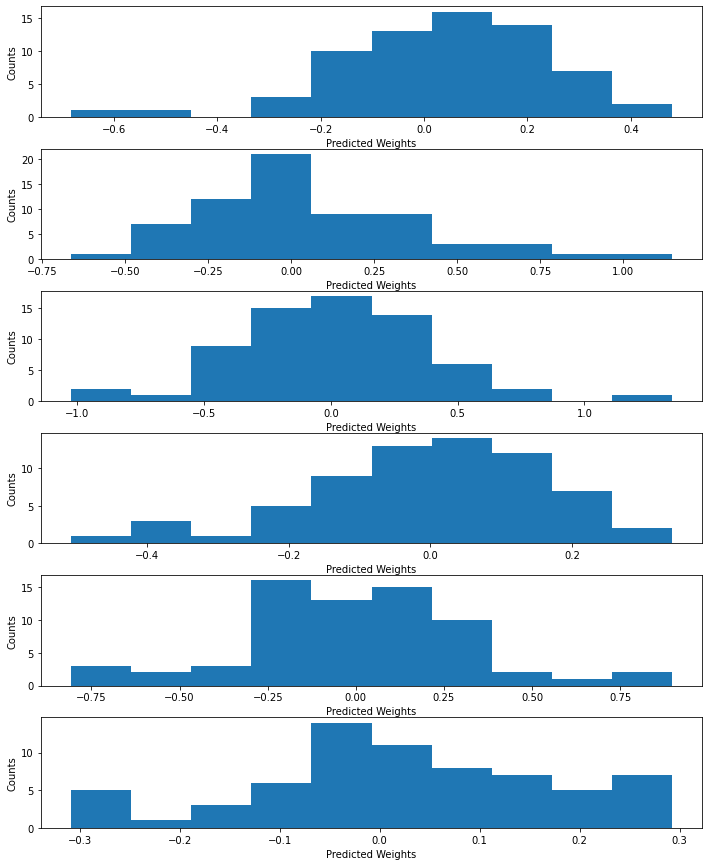

In [ ]:
from scipy import stats

#print(np.array(accdata))
print((f'Mean accuracy over sessions: {np.mean(accdata):3f}'))

#print(np.array(nulldata))
print((f'Null model over sessions: {np.mean(nulldata):3f}'))

all_coefs = np.zeros((67, 6))

# Index the weight of all successful sessions
for i in range(67):

  all_coefs[i] = glms[i].coef_

# Calculate the mean and the standard error
mean = np.mean(all_coefs, axis=0)
std_error = np.std(all_coefs) / np.sqrt(len(all_coefs))

# Calculate the t-statistics, known mean is 0
t = abs(mean) / std_error

t_critical_value = stats.t.ppf(q=0.975, df=11)

p_value = 2*(1-stats.t.cdf(x=t, df=11))

#print(f't_critical_value for session {i+1}: {t_critical_value}')
print(f'p_values: {p_value}')

# Plots histograms for predicted weights for our 6 regressors
figure, axis = plt.subplots(6, figsize=(10,12))
figure.tight_layout()

for i in range(6):
  counts, bins = np.histogram(all_coefs[:,i])
  axis[i].set_xlabel('Predicted Weights')
  axis[i].set_ylabel('Counts')
  axis[i].hist(bins[:-1], bins, weights=counts)


Plots the p-values over trials. The p-value for the first two coefficients reached close to signficant levels. For greater number of sessionos, we may see more signficance between the null model and our model.

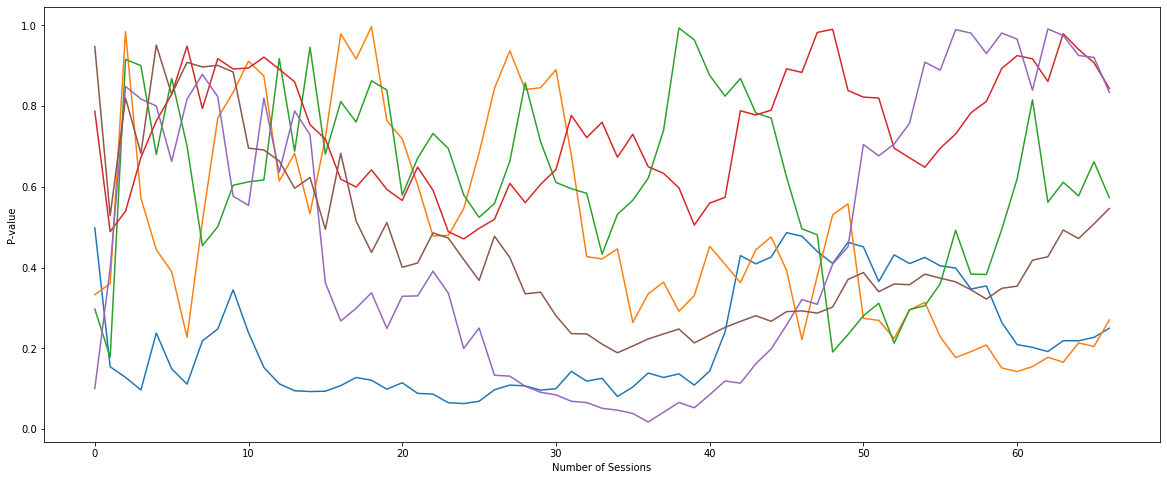

In [ ]:
p_values = []

all_coefs = np.zeros((67, 6))

# Index the weight of all successful sessions
for i in range(67):

  all_coefs[i] = glms[i].coef_

  mean = np.mean(all_coefs, axis=0)
  std_error = np.std(all_coefs) / np.sqrt(len(all_coefs))
  # Calculate the t-statistics, known mean is 0
  t = abs(mean) / std_error

  t_critical_value = stats.t.ppf(q=0.975, df=11)

  p_value = 2*(1-stats.t.cdf(x=t, df=11))

  p_values.append(p_value)

plt.figure(figsize=(20,8))
plt.plot(p_values)
plt.ylabel('P-value')
plt.xlabel('Number of Sessions')
plt.show()


# Additional investigations
In addition to logistic regression for three brain regions, we explored if there were any significant differences in accuracy if we ran the regression with two brain regions.  

Runs the logistic regression for two brain region over 83 sessions. The sets of brain regions are the visual cortex and CA1 hippocampus, CA1 hippocampus and thalamus, and visual cortext and thalamus.

In [ ]:
# Empty lists to store data for accuracy, null model, and coefficients
accdata_VIS_CA1 = []
nulldata_VIS_CA1 = []
glms_VIS_CA1 = []

accdata_CA1_PO = []
nulldata_CA1_PO = []
glms_CA1_PO = []

accdata_VIS_PO = []
nulldata_VIS_PO = []
glms_VIS_PO = []

for i in range(83):
  try:
    trials = one.load_object(one.pid2eid(pids[i])[0], 'trials')

    corr_coef_matrix_all_trials = np.zeros((len(trials['stimOn_times']), 3))

    ts = trials['stimOn_times'] + np.linspace(-.4,0,20).reshape((-1,1))
    ts = ts.T
    intervals = np.vstack((np.ndarray.flatten(ts[:,0:-1]), np.ndarray.flatten(ts[:,1:]))).T

    matrix, cluster_ids_out = decode.get_spike_counts_in_bins(spikes['times'],
                                                          spikes['clusters'],
                                                          intervals=intervals)

    # Calculate the accuracy, predicted, probability predicted, null model, and the coefficients of logistic regression ran on two brain regions
    acc1, pred1, prob1, null1, glm1 = logistic_regression(get_corr_coef_matrix_two_regions(VIS_neurons, CA1_neurons))
    acc2, pred2, prob2, null2, glm2 = logistic_regression(get_corr_coef_matrix_two_regions(CA1_neurons, PO_neurons))
    acc3, pred3, prob3, null3, glm3 = logistic_regression(get_corr_coef_matrix_two_regions(VIS_neurons, PO_neurons))

    # Append data onto the empty list
    accdata_VIS_CA1.append(acc1)
    nulldata_VIS_CA1.append(max(null1, 1-null1))

    accdata_CA1_PO.append(acc2)
    nulldata_CA1_PO.append(max(null2, 1-null2))

    accdata_VIS_PO.append(acc3)
    nulldata_VIS_PO.append(max(null3, 1-null3))

    glms_VIS_CA1.append(glm1)
    glms_CA1_PO.append(glm2)
    glms_VIS_PO.append(glm3)

  except:
    continue



/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: 

Prints the accuracy and the null model for the logistic regression ran on sets of brain regions over mutiple sessions. The definition of mean accuracy and null is the same as above. While the accuracy for the corrleation between two brain regions is higher than the null model, the accuracy is the same with other sets of brain regions. This results is because the accuracy is matching chance levels.

In [ ]:
# Print the accuracy and null model results of our regression
print(np.array(accdata_VIS_CA1))
print((f'Mean accuracy over sessions: {np.mean(accdata_VIS_CA1):3f}'))
#print(np.array(nulldata_VIS_CA1))
print((f'Null over sessions: {np.mean(nulldata_VIS_CA1):3f}'))

print(np.array(accdata_CA1_PO))
print((f'Mean accuracy over sessions: {np.mean(accdata_CA1_PO):3f}'))
#print(np.array(nulldata_CA1_PO))
print((f'Null over sessions: {np.mean(nulldata_CA1_PO):3f}'))

print(np.array(accdata_VIS_PO))
print((f'Mean accuracy over sessions: {np.mean(accdata_VIS_PO):3f}'))
#print(np.array(nulldata_VIS_PO))
print((f'Null over sessions: {np.mean(nulldata_VIS_PO):3f}'))

[0.75264271 0.74895978 0.81629116 0.72463768 0.79757576 0.54684838
 0.75909879 0.79947917 0.7823219  0.94851485 0.77118644 0.7759434
 0.71072319 0.88449848 0.82107843 0.80752212 0.8170564  0.71658986
 0.6344086  0.72941176 0.81884058 0.784      0.76079137 0.7284345
 0.78980892 0.71490593 0.6959799  0.80805687 0.78383838 0.82469512
 0.7972561  0.81841432 0.79614767 0.77232925 0.79551122 0.74682307
 0.86431227 0.74146341 0.87162162 0.73731077 0.84340932 0.77339346
 0.75804376 0.63137255 0.71038251 0.8112     0.82442748 0.74757282
 0.79032258 0.84832215 0.8681592  0.77988615 0.8447205  0.71509972
 0.82       0.47953216 0.66071429 0.77647059 0.81092012 0.71571072
 0.84460695 0.86822529 0.66779661 0.79689367 0.62234043 0.87127159
 0.89536266]
Mean accuracy over sessions: 0.772709
Null over sessions: 0.640509
[0.75264271 0.74895978 0.81629116 0.72463768 0.79757576 0.54684838
 0.75909879 0.79947917 0.7823219  0.94851485 0.77118644 0.7759434
 0.71072319 0.88449848 0.82107843 0.80752212 0.81705

The coef_t_test function calculates the t-test results for the predicted weights. The plot_coef function plots the predicted weights distribution over all 83 sessions.

In [ ]:
def coef_t_test(glms):

  for i in range(67):
    all_coefs[i] = glms[i].coef_

  mean = np.mean(all_coefs, axis=0)
  std_error = np.std(all_coefs) / np.sqrt(len(all_coefs))

  # Calculate the t-statistics, known mean is 0
  t = abs(mean) / std_error

  t_critical_value = stats.t.ppf(q=0.975, df=11)

  p_value = 2*(1-stats.t.cdf(x=t, df=11))

  #print(f't_critical_value for session {i+1}: {t_critical_value}')
  print(f'p_values: {p_value}')

def plot_coefs(glms):

  for i in range(6):
    all_coefs[i] = glms[i].coef_

  figure, axis = plt.subplots(6, figsize=(10,12))
  figure.tight_layout()

  # Plot histograms
  for i in range(6):
    counts, bins = np.histogram(all_coefs[:,i])
    axis[i].set_xlabel('Predicted Weights')
    axis[i].set_ylabel('Counts')
    axis[i].hist(bins[:-1], bins, weights=counts)


The t-test results for all sets of two brain regions. The p-values are exactly similar to each other because the results are only from chance.

In [ ]:
coef_t_test(glms_VIS_CA1)
coef_t_test(glms_CA1_PO)
coef_t_test(glms_VIS_PO)

p_values: [0.24994578 0.27028149 0.57328426 0.8441208  0.83436511 0.54672035]
p_values: [0.24994578 0.27028149 0.57328426 0.8441208  0.83436511 0.54672035]
p_values: [0.24994578 0.27028149 0.57328426 0.8441208  0.83436511 0.54672035]


Plots the histogram of our coefficients from the logistic regression on different sets of two brain regions. All the histograms were similar.

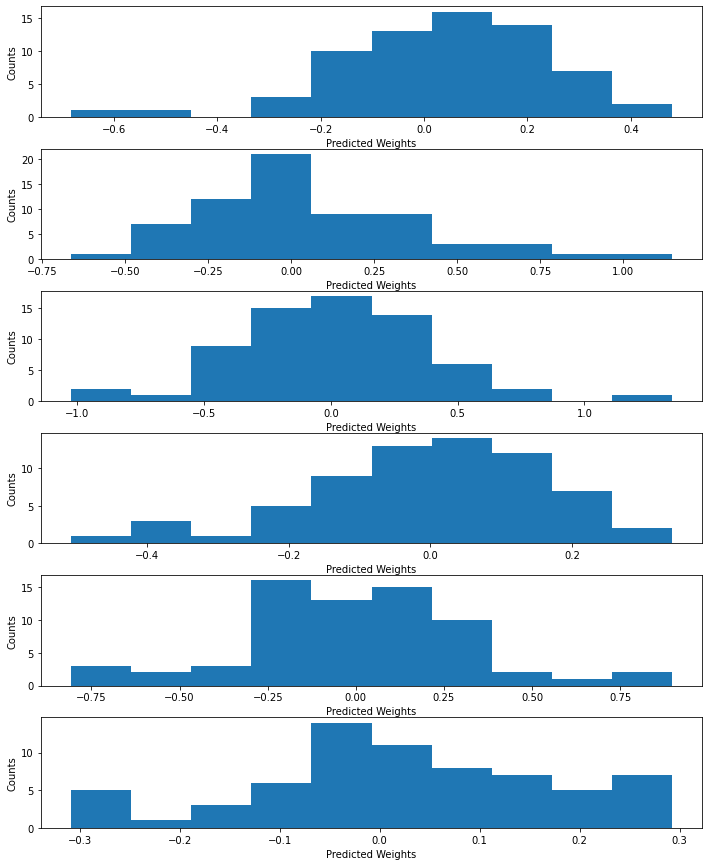

In [ ]:
plot_coefs(glms_VIS_CA1)

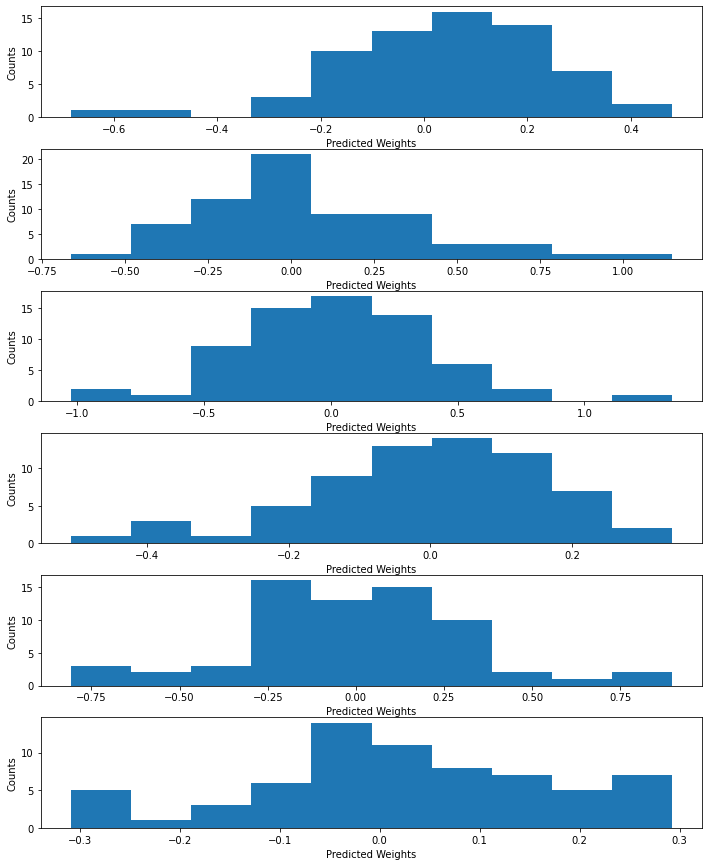

In [ ]:
plot_coefs(glms_CA1_PO)

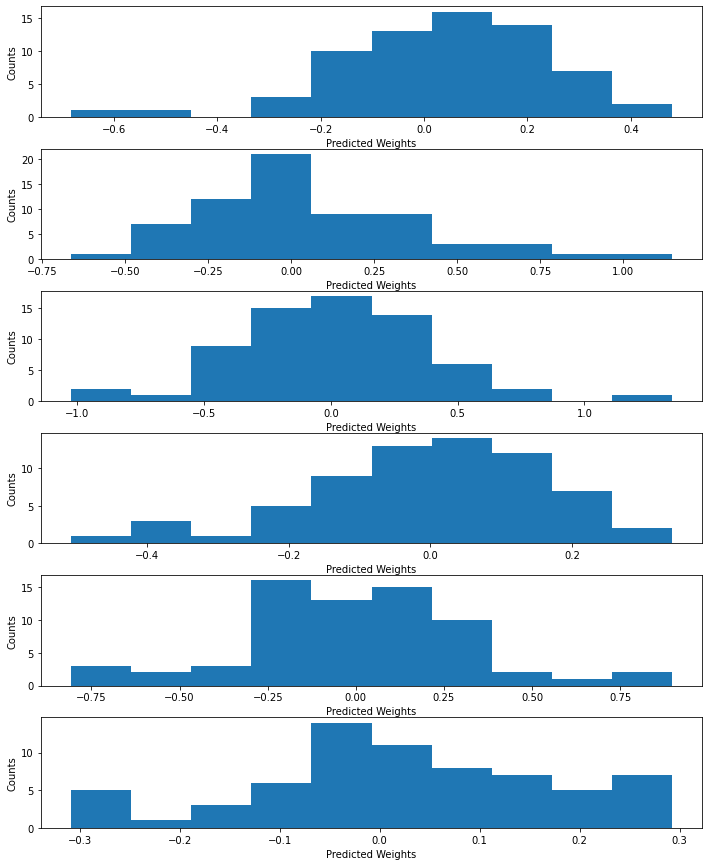

In [ ]:
plot_coefs(glms_VIS_PO)

PCA of one sessions. We ran PCA to test the accuracy of our model for one session. The accuracy did not improve significantly from our model.

The variance decreases after first principal component. There is a significant correlation between brain regions before movement. The first principal component is capturing large changes in global brain activity. Research has indicated tweaking in whiskers results in increased variance explained for the first few principal components.

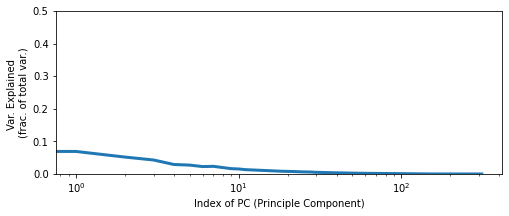

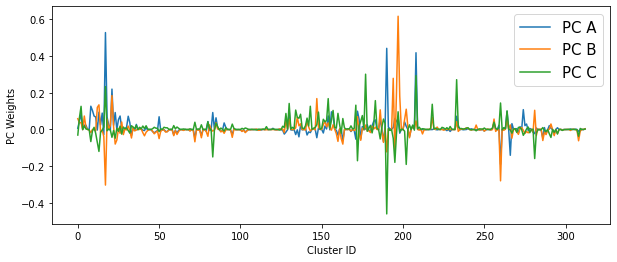

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


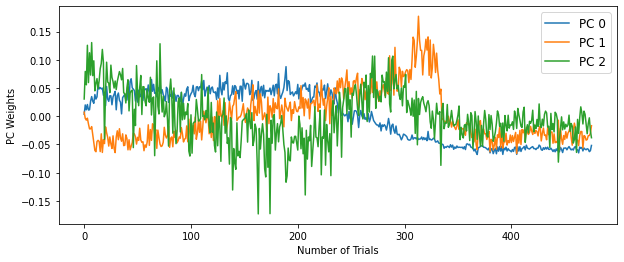

In [ ]:
# Index the probe of the first session
trials = one.load_object(one.pid2eid(pids[0])[0], 'trials')

# Replace no reward with 0 fo regression
y = trials['feedbackType']
y[y == -1] = 0

matrix, cluster_ids_out = decode.get_spike_counts_in_bins(spikes['times'],
                                                          spikes['clusters'],
                                                          intervals=np.vstack((trials['stimOn_times'] - 0.4, trials['stimOn_times'])).T)


# Index the brain region activity
brain_region_activity1 = np.take(matrix, indices=VIS_neurons, axis=0)
brain_region_activity2 = np.take(matrix, indices=CA1_neurons, axis=0)
brain_region_activity3 = np.take(matrix, indices=PO_neurons, axis=0)

# Combine the brain region activity for PCA
X = np.vstack((brain_region_activity1, brain_region_activity2, brain_region_activity3))

X = X - np.reshape(np.mean(X,axis=1),(X.shape[0],1))

w_c, v_c = np.linalg.eig(np.matmul(X,X.T))
w_t, v_t = np.linalg.eig(np.matmul(X.T,X))

plt.figure(figsize=(8,3))
plt.plot(w_c/np.sum(w_c),lw=3)
# plt.plot(w_t/np.sum(w_t),lw=3) # verified that this gives the same as above
plt.ylabel('Var. Explained \n(frac. of total var.)')
plt.xlabel('Index of PC (Principle Component)')
plt.ylim(0, 0.5)
plt.xscale('log')
plt.show()
print('')

NPCs = 3

plt.figure(figsize=(10,4))
for i in range(NPCs):
  plt.plot(v_c[:,i])
# plt.legend([f'PC {pi}' for pi in range(NPCs)], fontsize=12)
plt.legend(['PC A', 'PC B', 'PC C'], fontsize=15)
plt.ylabel('PC Weights')
plt.xlabel('Cluster ID')
plt.show()
print('')

plt.figure(figsize=(10,4))
for i in range(NPCs):
  plt.plot(v_t[:,i])
plt.legend([f'PC {pi}' for pi in range(NPCs)], fontsize=12)
plt.ylabel('PC Weights')
plt.xlabel('Number of Trials')
plt.show()


The PCA results. PCA did not improve the accuracy signficantly from the test. Similarly, the PCA result was not signficantly better than the our logistic regression from results.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

for i in range(12):
  try:
    # Iterate over mutiple sessions
    trials = one.load_object(one.pid2eid(pids[i])[0], 'trials')

    y = trials['feedbackType']
    y[y == -1] = 0

    matrix, cluster_ids_out = decode.get_spike_counts_in_bins(spikes['times'],
                                                        spikes['clusters'],
                                                        intervals=np.vstack((trials['stimOn_times'] - 0.4, trials['stimOn_times'])).T)


    brain_region_activity1 = np.take(matrix, indices=VIS_neurons, axis=0)
    brain_region_activity2 = np.take(matrix, indices=CA1_neurons, axis=0)
    brain_region_activity3 = np.take(matrix, indices=PO_neurons, axis=0)

    X = np.vstack((brain_region_activity1, brain_region_activity2, brain_region_activity3)).T

    # Process X matrix
    sc = StandardScaler()
    X_scaled = sc.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=6)
    X_pca = pca.fit_transform(X_scaled)

    split = y.shape[0]

    X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca[:split,:], y, test_size=0.20,
                                                          shuffle=True, random_state=2)

    clf = LogisticRegression(max_iter=1e14)

    clf.fit(X_train_pca, y_train)

    # Make predictions based on logistic regression
    y_pred = clf.predict(X_test_pca)
    y_true = y_test # True values

    print("Train accuracy:", np.round(accuracy_score(y_train,
                                                clf.predict(X_train_pca)), 5))
    print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 5))

  except:
    continue

Train accuracy: 0.76842
Test accuracy: 0.72917
Train accuracy: 0.74611
Test accuracy: 0.75862
Train accuracy: 0.81897
Test accuracy: 0.78448
Train accuracy: 0.73273
Test accuracy: 0.72619
Train accuracy: 0.80363
Test accuracy: 0.77108
Train accuracy: 0.56503
Test accuracy: 0.48305
Train accuracy: 0.7694
Test accuracy: 0.7094
Train accuracy: 0.80227
Test accuracy: 0.79355
Train accuracy: 0.78232
Test accuracy: 0.76471
